### This notebook outputs the relative importances of the conjoint analysis on the contribution of project tags combinations at two different cost levels - high and low, towards the budget utilization by equal shares and utilitarian greedy respectively

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import csv

In [2]:
# use this code block to set column and row viewing size/width
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', 100)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199

pd.options.display.float_format = '{:.6f}'.format

In [3]:
# read the metadata csv
pbsummary_df = pd.read_csv('../metadata.csv', delimiter=';')
pbsummary_df = pbsummary_df.drop_duplicates()
pbsummary_df

pbsummary_aarau = pd.read_csv('../metadata_aarau.csv', delimiter=';')

pbsummary_df = pd.concat([pbsummary_df, pbsummary_aarau], ignore_index=True)

pbsummary_df['subunit'].fillna(value='all', inplace=True)

In [4]:
# Get election id and vote type, so we know better to segragate approval and score votings
pbsummary_with_vote_type = pbsummary_df[['election_id', 'vote_type']]
print(pbsummary_with_vote_type.head())
print(pbsummary_with_vote_type['vote_type'].value_counts())

   election_id   vote_type
0            1  cumulative
1            2  cumulative
2            3  cumulative
3            4  cumulative
4            5  cumulative
vote_type
approval      613
cumulative    104
ordinal        95
Name: count, dtype: int64


In [5]:
# reading the projects CSV and loading to dataframe
pbprojects_df = pd.read_csv('../projects.csv', delimiter=';')
pbprojects_df.drop_duplicates(inplace=True)
print(pbprojects_df.shape)

pbprojects_aarau = pd.read_csv('../projects_aarau.csv', delimiter=';')
pbprojects_df = pd.concat([pbprojects_df, pbprojects_aarau], ignore_index=True)

# merge the column vote_type into pbprojects_df
pbprojects_df = pd.merge(pbprojects_df, pbsummary_with_vote_type, on='election_id', how='inner')
print(pbprojects_df.shape)

pbprojects_df.head()

(19077, 21)
(19110, 22)


,election_id,country,unit,subunit,instance,project_id,cost,project_voters_count,votes,score,category,name,englishName,target,total_budget,budget_percent,is_mes_winner,is_greedy_winner,is_phragmen_winner,latitude,longitude,vote_type
0,1,France,Toulouse,ARENES,2019,1,7000,1494,215,NaN,NaN,Compostons ensemble !,NaN,NaN,1000000.000000,0.700000,True,True,True,NaN,NaN,cumulative
1,1,France,Toulouse,BELLEFONTAINE MILAN,2019,2,35000,1494,26,NaN,NaN,Panneau d'affichage électronique extérieur,NaN,NaN,1000000.000000,3.500000,False,False,False,NaN,NaN,cumulative
2,1,France,Toulouse,ARENES,2019,3,50000,1494,92,NaN,NaN,Eclairage public d’un chemin piéton-vélo rue Ella Maillart,NaN,NaN,1000000.000000,5.000000,True,False,True,NaN,NaN,cumulative
3,1,France,Toulouse,PRADETTES,2019,4,390000,1494,471,NaN,NaN,"Tous à la Ramée à vélo ! A pied, en trottinette et rollers !",NaN,NaN,1000000.000000,39.000000,False,True,False,NaN,NaN,cumulative
4,1,France,Toulouse,NEGRENEYS,2019,5,168000,1494,205,NaN,NaN,Le parc des Anges vu par ses usagers,NaN,NaN,1000000.000000,16.800000,True,True,True,NaN,NaN,cumulative


In [6]:
# There are citywide elections (unit-level); i.e. subunit is na, for such records fill na columns with values for subunit as all
pbprojects_df['subunit'].fillna(value='all', inplace=True)

# Cross checking for projects where by we have filled with subunit equalling the value 'all'
print(pbprojects_df[pbprojects_df['subunit'] == 'all'].shape)
print("Valid PB projects are: ", pbprojects_df.shape)

(1928, 22)
Valid PB projects are:  (19110, 22)


In [7]:
valid_pbprojects_df = pbprojects_df[(~pbprojects_df['category'].isna())] # we want to select only those instances for which there are category tags

total_election_projects_cost = valid_pbprojects_df.groupby(['election_id'])['cost'].sum().reset_index()
total_election_projects_cost.rename(columns={'cost': 'total_election_projects_cost'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(total_election_projects_cost, on='election_id', how='inner')

total_mes_winners_cost = valid_pbprojects_df[(valid_pbprojects_df['is_mes_winner'] == True)].groupby(['election_id'])['cost'].sum().reset_index()
total_mes_winners_cost.rename(columns={'cost': 'total_mes_winners_cost'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(total_mes_winners_cost, on='election_id', how='inner')

total_ug_winners_cost = valid_pbprojects_df[(valid_pbprojects_df['is_greedy_winner'] == True)].groupby(['election_id'])['cost'].sum().reset_index()
total_ug_winners_cost.rename(columns={'cost': 'total_ug_winners_cost'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(total_ug_winners_cost, on='election_id', how='inner')

num_projects = valid_pbprojects_df.groupby(['election_id'])['project_id'].count().reset_index()
num_projects.rename(columns={'project_id': 'num_projects'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(num_projects, on='election_id', how='inner')

num_mes_winners = valid_pbprojects_df[(valid_pbprojects_df['is_mes_winner'] == True)].groupby(['election_id'])['project_id'].count().reset_index()
num_mes_winners.rename(columns={'project_id': 'num_mes_winners'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(num_mes_winners, on='election_id', how='inner')

num_ug_winners = valid_pbprojects_df[(valid_pbprojects_df['is_greedy_winner'] == True)].groupby(['election_id'])['project_id'].count().reset_index()
num_ug_winners.rename(columns={'project_id': 'num_ug_winners'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(num_ug_winners, on='election_id', how='inner')

In [8]:
valid_pbprojects_df[valid_pbprojects_df['election_id'] == 332]

,election_id,country,unit,subunit,instance,project_id,cost,project_voters_count,votes,score,category,name,englishName,target,total_budget,budget_percent,is_mes_winner,is_greedy_winner,is_phragmen_winner,latitude,longitude,vote_type,total_election_projects_cost,total_mes_winners_cost,total_ug_winners_cost,num_projects,num_mes_winners,num_ug_winners
0,332,Poland,Warszawa,Aleksandrów,2017,261,80000,422,172,NaN,"public transit and roads,public space",REMONT NAWIERZCHNI PŁYTOWEJ ULICY ZAGÓRZAŃSKIEJ OD NR 50D DO KOŃCA W STRONĘ LASU,NaN,"adults,families with children",110411.000000,72.457000,False,True,False,NaN,NaN,approval,287217,107950,110000,5,3,2
1,332,Poland,Warszawa,Aleksandrów,2017,1112,99267,422,140,NaN,public transit and roads,UTWARDZENIE NAWIERZCHNI NA ULICY JASNOTY,NaN,"adults,seniors,families with children",110411.000000,89.907000,False,False,False,NaN,NaN,approval,287217,107950,110000,5,3,2
2,332,Poland,Warszawa,Aleksandrów,2017,720,30000,422,118,NaN,"public space,education,culture",Artystyczna pracownia letnia,NaN,NaN,110411.000000,27.171000,True,True,True,NaN,NaN,approval,287217,107950,110000,5,3,2
3,332,Poland,Warszawa,Aleksandrów,2017,1206,9200,422,99,NaN,"education,sport",Bezpieczna Kobieta - Kurs samoobrony,NaN,"adults,seniors",110411.000000,8.333000,True,False,True,NaN,NaN,approval,287217,107950,110000,5,3,2
4,332,Poland,Warszawa,Aleksandrów,2017,2592,68750,422,86,NaN,public transit and roads,Budowa chodnika w ul. Optymistów,NaN,"children,youth,adults",110411.000000,62.267000,True,False,True,NaN,NaN,approval,287217,107950,110000,5,3,2


In [9]:
## additional columns for whether a project lies in a given cost quartile or not
q2_df = valid_pbprojects_df.groupby(['election_id'])['cost'].quantile(0.5).reset_index()
q2_df.rename(columns={'cost': 'cost_margin'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(q2_df, on='election_id', how='inner')


# Initialize 4 different columns for labels
valid_pbprojects_df['low_cost'] = 0
valid_pbprojects_df['high_cost'] = 0

# Iterate through rows and update the new columns
for index, row in valid_pbprojects_df.iterrows():
    if row['cost'] <= row['cost_margin']:
        valid_pbprojects_df.at[index, 'low_cost'] = 1
    else:
        valid_pbprojects_df.at[index, 'high_cost'] = 1

In [10]:
valid_pbprojects_df

,election_id,country,unit,subunit,instance,project_id,cost,project_voters_count,votes,score,category,name,englishName,target,total_budget,budget_percent,is_mes_winner,is_greedy_winner,is_phragmen_winner,latitude,longitude,vote_type,total_election_projects_cost,total_mes_winners_cost,total_ug_winners_cost,num_projects,num_mes_winners,num_ug_winners,cost_margin,low_cost,high_cost
0,332,Poland,Warszawa,Aleksandrów,2017,261,80000,422,172,NaN,"public transit and roads,public space",REMONT NAWIERZCHNI PŁYTOWEJ ULICY ZAGÓRZAŃSKIEJ OD NR 50D DO KOŃCA W STRONĘ LASU,NaN,"adults,families with children",110411.000000,72.457000,False,True,False,NaN,NaN,approval,287217,107950,110000,5,3,2,68750.000000,0,1
1,332,Poland,Warszawa,Aleksandrów,2017,1112,99267,422,140,NaN,public transit and roads,UTWARDZENIE NAWIERZCHNI NA ULICY JASNOTY,NaN,"adults,seniors,families with children",110411.000000,89.907000,False,False,False,NaN,NaN,approval,287217,107950,110000,5,3,2,68750.000000,0,1
2,332,Poland,Warszawa,Aleksandrów,2017,720,30000,422,118,NaN,"public space,education,culture",Artystyczna pracownia letnia,NaN,NaN,110411.000000,27.171000,True,True,True,NaN,NaN,approval,287217,107950,110000,5,3,2,68750.000000,1,0
3,332,Poland,Warszawa,Aleksandrów,2017,1206,9200,422,99,NaN,"education,sport",Bezpieczna Kobieta - Kurs samoobrony,NaN,"adults,seniors",110411.000000,8.333000,True,False,True,NaN,NaN,approval,287217,107950,110000,5,3,2,68750.000000,1,0
4,332,Poland,Warszawa,Aleksandrów,2017,2592,68750,422,86,NaN,public transit and roads,Budowa chodnika w ul. Optymistów,NaN,"children,youth,adults",110411.000000,62.267000,True,False,True,NaN,NaN,approval,287217,107950,110000,5,3,2,68750.000000,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10922,1000,Switzerland,Aarau,Aarau,2023,18,5000,1703,88,146.000000,"health,education,welfare",Processing birth,NaN,"adults,families with children",50000.000000,10.000000,False,False,False,NaN,NaN,cumulative,247330,49400,49600,33,17,7,4000.000000,0,1
10923,1000,Switzerland,Aarau,Aarau,2023,17,3500,1703,67,102.000000,welfare,Senior Meeting,NaN,elderly,50000.000000,7.000000,False,False,False,NaN,NaN,cumulative,247330,49400,49600,33,17,7,4000.000000,1,0
10924,1000,Switzerland,Aarau,Aarau,2023,27,4000,1703,69,97.000000,"public space,public transit and roads",New edition of Telli-Map,NaN,"children,families with children,elderly",50000.000000,8.000000,False,False,False,NaN,NaN,cumulative,247330,49400,49600,33,17,7,4000.000000,1,0
10925,1000,Switzerland,Aarau,Aarau,2023,19,500,1703,56,85.000000,"welfare,education,health",Ways of Remembering,NaN,"youth,adults,elderly",50000.000000,1.000000,True,False,True,NaN,NaN,cumulative,247330,49400,49600,33,17,7,4000.000000,1,0


In [11]:
# dependent variables 
valid_pbprojects_df['mes_budget_utilization'] = 1.000000 * valid_pbprojects_df['total_mes_winners_cost'] / valid_pbprojects_df['total_budget']
valid_pbprojects_df['mes_cost_representation'] = 1.000000 * valid_pbprojects_df['total_mes_winners_cost'] / valid_pbprojects_df['total_election_projects_cost']
valid_pbprojects_df['mes_winning_rate'] = 1.000000 * valid_pbprojects_df['num_mes_winners'] / valid_pbprojects_df['num_projects']

valid_pbprojects_df['greedy_budget_utilization'] = 1.000000 * valid_pbprojects_df['total_ug_winners_cost'] / valid_pbprojects_df['total_budget']
valid_pbprojects_df['greedy_cost_representation'] = 1.000000 * valid_pbprojects_df['total_ug_winners_cost'] / valid_pbprojects_df['total_election_projects_cost']
valid_pbprojects_df['greedy_winning_rate'] = 1.000000 * valid_pbprojects_df['num_ug_winners'] / valid_pbprojects_df['num_projects']

In [12]:
# Function to sort and join the values in each row
def unifyCategories(row):
    values = row['category'].split(',')
    sorted_values = sorted(set(values))
    return ','.join(sorted_values)

# There are duplicated order of categories such as culture, welfare is also put while welfare, culture is also put, create a new column called set_categories that stores set of distinct elements
valid_pbprojects_df['sorted_categories'] = valid_pbprojects_df.apply(lambda row: unifyCategories(row), axis=1)
distinct_category_counts = valid_pbprojects_df['sorted_categories'].value_counts()

print(valid_pbprojects_df.columns)

print(valid_pbprojects_df.shape)

Index(['election_id', 'country', 'unit', 'subunit', 'instance', 'project_id',
       'cost', 'project_voters_count', 'votes', 'score', 'category', 'name',
       'englishName', 'target', 'total_budget', 'budget_percent',
       'is_mes_winner', 'is_greedy_winner', 'is_phragmen_winner', 'latitude',
       'longitude', 'vote_type', 'total_election_projects_cost',
       'total_mes_winners_cost', 'total_ug_winners_cost', 'num_projects',
       'num_mes_winners', 'num_ug_winners', 'cost_margin', 'low_cost',
       'high_cost', 'mes_budget_utilization', 'mes_cost_representation',
       'mes_winning_rate', 'greedy_budget_utilization',
       'greedy_cost_representation', 'greedy_winning_rate',
       'sorted_categories'],
      dtype='object')
(10927, 38)


In [13]:
## function to identify whether a given set of tag is in the winning outcome by mes or ug or not
## we select top five columns out of all combinations such that all kinds of projects are covered
# the top five combination of categories is fetched from a different notebook; please contact if details required
top_five_categories_set = [ 'culture,education', 
                           'culture,education,welfare', 
                           'environmental protection,public space,urban greenery', 
                           'health,public space,sport', 
                           'public space,public transit and roads' ]

print(top_five_categories_set)

['culture,education', 'culture,education,welfare', 'environmental protection,public space,urban greenery', 'health,public space,sport', 'public space,public transit and roads']


In [14]:
## introduce new columns for nested category winners with cost quartile levels; 
# three way check - if project is a winner; if project is a tag combo; if project's cost lies below quartile cost

# for MES
valid_pbprojects_df['is_mes_winner_combo_culture_education_and_low_cost'] = ((valid_pbprojects_df['is_mes_winner'] == True) & (valid_pbprojects_df['sorted_categories'] == 'culture,education') & (valid_pbprojects_df['low_cost'] == 1)).astype(int)
valid_pbprojects_df['is_mes_winner_combo_culture_education_and_high_cost'] = ((valid_pbprojects_df['is_mes_winner'] == True) & (valid_pbprojects_df['sorted_categories'] == 'culture,education') & (valid_pbprojects_df['high_cost'] == 1)).astype(int)

valid_pbprojects_df['is_mes_winner_combo_env_pspace_ugreen_and_low_cost'] = ((valid_pbprojects_df['is_mes_winner'] == True) & (valid_pbprojects_df['sorted_categories'] == 'environmental protection,public space,urban greenery') & (valid_pbprojects_df['low_cost'] == 1)).astype(int)
valid_pbprojects_df['is_mes_winner_combo_env_pspace_ugreen_and_high_cost'] = ((valid_pbprojects_df['is_mes_winner'] == True) & (valid_pbprojects_df['sorted_categories'] == 'environmental protection,public space,urban greenery') & (valid_pbprojects_df['high_cost'] == 1)).astype(int)

valid_pbprojects_df['is_mes_winner_combo_health_pspace_sport_and_low_cost'] = ((valid_pbprojects_df['is_mes_winner'] == True) & (valid_pbprojects_df['sorted_categories'] == 'health,public space,sport') & (valid_pbprojects_df['low_cost'] == 1)).astype(int)
valid_pbprojects_df['is_mes_winner_combo_health_pspace_sport_and_high_cost'] = ((valid_pbprojects_df['is_mes_winner'] == True) & (valid_pbprojects_df['sorted_categories'] == 'health,public space,sport') & (valid_pbprojects_df['high_cost'] == 1)).astype(int)

valid_pbprojects_df['is_mes_winner_combo_pspace_ptransit_and_low_cost'] = ((valid_pbprojects_df['is_mes_winner'] == True) & (valid_pbprojects_df['sorted_categories'] == 'public space,public transit and roads') & (valid_pbprojects_df['low_cost'] == 1)).astype(int)
valid_pbprojects_df['is_mes_winner_combo_pspace_ptransit_and_high_cost'] = ((valid_pbprojects_df['is_mes_winner'] == True) & (valid_pbprojects_df['sorted_categories'] == 'public space,public transit and roads') & (valid_pbprojects_df['high_cost'] == 1)).astype(int)

# for UG
valid_pbprojects_df['is_greedy_winner_combo_culture_education_and_low_cost'] = ((valid_pbprojects_df['is_greedy_winner'] == True) & (valid_pbprojects_df['sorted_categories'] == 'culture,education') & (valid_pbprojects_df['low_cost'] == 1)).astype(int)
valid_pbprojects_df['is_greedy_winner_combo_culture_education_and_high_cost'] = ((valid_pbprojects_df['is_greedy_winner'] == True) & (valid_pbprojects_df['sorted_categories'] == 'culture,education') & (valid_pbprojects_df['high_cost'] == 1)).astype(int)

valid_pbprojects_df['is_greedy_winner_combo_env_pspace_ugreen_and_low_cost'] = ((valid_pbprojects_df['is_greedy_winner'] == True) & (valid_pbprojects_df['sorted_categories'] == 'environmental protection,public space,urban greenery') & (valid_pbprojects_df['low_cost'] == 1)).astype(int)
valid_pbprojects_df['is_greedy_winner_combo_env_pspace_ugreen_and_high_cost'] = ((valid_pbprojects_df['is_greedy_winner'] == True) & (valid_pbprojects_df['sorted_categories'] == 'environmental protection,public space,urban greenery') & (valid_pbprojects_df['high_cost'] == 1)).astype(int)

valid_pbprojects_df['is_greedy_winner_combo_health_pspace_sport_and_low_cost'] = ((valid_pbprojects_df['is_greedy_winner'] == True) & (valid_pbprojects_df['sorted_categories'] == 'health,public space,sport') & (valid_pbprojects_df['low_cost'] == 1)).astype(int)
valid_pbprojects_df['is_greedy_winner_combo_health_pspace_sport_and_high_cost'] = ((valid_pbprojects_df['is_greedy_winner'] == True) & (valid_pbprojects_df['sorted_categories'] == 'health,public space,sport') & (valid_pbprojects_df['high_cost'] == 1)).astype(int)

valid_pbprojects_df['is_greedy_winner_combo_pspace_ptransit_and_low_cost'] = ((valid_pbprojects_df['is_greedy_winner'] == True) & (valid_pbprojects_df['sorted_categories'] == 'public space,public transit and roads') & (valid_pbprojects_df['low_cost'] == 1)).astype(int)
valid_pbprojects_df['is_greedy_winner_combo_pspace_ptransit_and_high_cost'] = ((valid_pbprojects_df['is_greedy_winner'] == True) & (valid_pbprojects_df['sorted_categories'] == 'public space,public transit and roads') & (valid_pbprojects_df['high_cost'] == 1)).astype(int)


print(valid_pbprojects_df.shape) # 16 new columns added; 10863 x 54

(10927, 54)


In [15]:
# For MES, grouping 16 combo with cost quartile levels, and thus adding another 8 columns with set values
mes_winner_combo_culture_education_and_low_cost_set = valid_pbprojects_df.groupby(['election_id'])['is_mes_winner_combo_culture_education_and_low_cost'].agg(set).reset_index()
mes_winner_combo_culture_education_and_low_cost_set.rename(columns={'is_mes_winner_combo_culture_education_and_low_cost': 'mes_combo_culture_education_low_cost_set'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(mes_winner_combo_culture_education_and_low_cost_set, on='election_id', how='inner')

mes_winner_combo_culture_education_and_high_cost_set = valid_pbprojects_df.groupby(['election_id'])['is_mes_winner_combo_culture_education_and_high_cost'].agg(set).reset_index()
mes_winner_combo_culture_education_and_high_cost_set.rename(columns={'is_mes_winner_combo_culture_education_and_high_cost': 'mes_combo_culture_education_high_cost_set'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(mes_winner_combo_culture_education_and_high_cost_set, on='election_id', how='inner')
##
mes_winner_combo_env_pspace_ugreen_and_low_cost_set = valid_pbprojects_df.groupby(['election_id'])['is_mes_winner_combo_env_pspace_ugreen_and_low_cost'].agg(set).reset_index()
mes_winner_combo_env_pspace_ugreen_and_low_cost_set.rename(columns={'is_mes_winner_combo_env_pspace_ugreen_and_low_cost': 'mes_combo_env_pspace_ugreen_low_cost_set'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(mes_winner_combo_env_pspace_ugreen_and_low_cost_set, on='election_id', how='inner')

mes_winner_combo_env_pspace_ugreen_and_high_cost_set = valid_pbprojects_df.groupby(['election_id'])['is_mes_winner_combo_env_pspace_ugreen_and_high_cost'].agg(set).reset_index()
mes_winner_combo_env_pspace_ugreen_and_high_cost_set.rename(columns={'is_mes_winner_combo_env_pspace_ugreen_and_high_cost': 'mes_combo_env_pspace_ugreen_high_cost_set'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(mes_winner_combo_env_pspace_ugreen_and_high_cost_set, on='election_id', how='inner')
##
mes_winner_combo_health_pspace_sport_and_low_cost_set = valid_pbprojects_df.groupby(['election_id'])['is_mes_winner_combo_health_pspace_sport_and_low_cost'].agg(set).reset_index()
mes_winner_combo_health_pspace_sport_and_low_cost_set.rename(columns={'is_mes_winner_combo_health_pspace_sport_and_low_cost': 'mes_combo_health_pspace_sport_low_cost_set'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(mes_winner_combo_health_pspace_sport_and_low_cost_set, on='election_id', how='inner')

mes_winner_combo_health_pspace_sport_and_high_cost_set = valid_pbprojects_df.groupby(['election_id'])['is_mes_winner_combo_health_pspace_sport_and_high_cost'].agg(set).reset_index()
mes_winner_combo_health_pspace_sport_and_high_cost_set.rename(columns={'is_mes_winner_combo_health_pspace_sport_and_high_cost': 'mes_combo_health_pspace_sport_high_cost_set'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(mes_winner_combo_health_pspace_sport_and_high_cost_set, on='election_id', how='inner')
##
mes_winner_combo_pspace_ptransit_and_low_cost_set = valid_pbprojects_df.groupby(['election_id'])['is_mes_winner_combo_pspace_ptransit_and_low_cost'].agg(set).reset_index()
mes_winner_combo_pspace_ptransit_and_low_cost_set.rename(columns={'is_mes_winner_combo_pspace_ptransit_and_low_cost': 'mes_combo_pspace_ptransit_low_cost_set'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(mes_winner_combo_pspace_ptransit_and_low_cost_set, on='election_id', how='inner')

mes_winner_combo_pspace_ptransit_and_high_cost_set = valid_pbprojects_df.groupby(['election_id'])['is_mes_winner_combo_pspace_ptransit_and_high_cost'].agg(set).reset_index()
mes_winner_combo_pspace_ptransit_and_high_cost_set.rename(columns={'is_mes_winner_combo_pspace_ptransit_and_high_cost': 'mes_combo_pspace_ptransit_high_cost_set'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(mes_winner_combo_pspace_ptransit_and_high_cost_set, on='election_id', how='inner')

print(valid_pbprojects_df.shape) # 8 new columns added for MES winners combo with quartile set; 10863 x 62

(10927, 62)


In [16]:
# For UG, grouping 16 combo with cost quartile levels, and thus adding another 8 columns with set values
greedy_winner_combo_culture_education_and_low_cost_set = valid_pbprojects_df.groupby(['election_id'])['is_greedy_winner_combo_culture_education_and_low_cost'].agg(set).reset_index()
greedy_winner_combo_culture_education_and_low_cost_set.rename(columns={'is_greedy_winner_combo_culture_education_and_low_cost': 'greedy_combo_culture_education_low_cost_set'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(greedy_winner_combo_culture_education_and_low_cost_set, on='election_id', how='inner')

greedy_winner_combo_culture_education_and_high_cost_set = valid_pbprojects_df.groupby(['election_id'])['is_greedy_winner_combo_culture_education_and_high_cost'].agg(set).reset_index()
greedy_winner_combo_culture_education_and_high_cost_set.rename(columns={'is_greedy_winner_combo_culture_education_and_high_cost': 'greedy_combo_culture_education_high_cost_set'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(greedy_winner_combo_culture_education_and_high_cost_set, on='election_id', how='inner')
##
greedy_winner_combo_env_pspace_ugreen_and_low_cost_set = valid_pbprojects_df.groupby(['election_id'])['is_greedy_winner_combo_env_pspace_ugreen_and_low_cost'].agg(set).reset_index()
greedy_winner_combo_env_pspace_ugreen_and_low_cost_set.rename(columns={'is_greedy_winner_combo_env_pspace_ugreen_and_low_cost': 'greedy_combo_env_pspace_ugreen_low_cost_set'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(greedy_winner_combo_env_pspace_ugreen_and_low_cost_set, on='election_id', how='inner')

greedy_winner_combo_env_pspace_ugreen_and_high_cost_set = valid_pbprojects_df.groupby(['election_id'])['is_greedy_winner_combo_env_pspace_ugreen_and_high_cost'].agg(set).reset_index()
greedy_winner_combo_env_pspace_ugreen_and_high_cost_set.rename(columns={'is_greedy_winner_combo_env_pspace_ugreen_and_high_cost': 'greedy_combo_env_pspace_ugreen_high_cost_set'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(greedy_winner_combo_env_pspace_ugreen_and_high_cost_set, on='election_id', how='inner')
##
greedy_winner_combo_health_pspace_sport_and_low_cost_set = valid_pbprojects_df.groupby(['election_id'])['is_greedy_winner_combo_health_pspace_sport_and_low_cost'].agg(set).reset_index()
greedy_winner_combo_health_pspace_sport_and_low_cost_set.rename(columns={'is_greedy_winner_combo_health_pspace_sport_and_low_cost': 'greedy_combo_health_pspace_sport_low_cost_set'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(greedy_winner_combo_health_pspace_sport_and_low_cost_set, on='election_id', how='inner')

greedy_winner_combo_health_pspace_sport_and_high_cost_set = valid_pbprojects_df.groupby(['election_id'])['is_greedy_winner_combo_health_pspace_sport_and_high_cost'].agg(set).reset_index()
greedy_winner_combo_health_pspace_sport_and_high_cost_set.rename(columns={'is_greedy_winner_combo_health_pspace_sport_and_high_cost': 'greedy_combo_health_pspace_sport_high_cost_set'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(greedy_winner_combo_health_pspace_sport_and_high_cost_set, on='election_id', how='inner')
##
greedy_winner_combo_pspace_ptransit_and_low_cost_set = valid_pbprojects_df.groupby(['election_id'])['is_greedy_winner_combo_pspace_ptransit_and_low_cost'].agg(set).reset_index()
greedy_winner_combo_pspace_ptransit_and_low_cost_set.rename(columns={'is_greedy_winner_combo_pspace_ptransit_and_low_cost': 'greedy_combo_pspace_ptransit_low_cost_set'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(greedy_winner_combo_pspace_ptransit_and_low_cost_set, on='election_id', how='inner')

greedy_winner_combo_pspace_ptransit_and_high_cost_set = valid_pbprojects_df.groupby(['election_id'])['is_greedy_winner_combo_pspace_ptransit_and_high_cost'].agg(set).reset_index()
greedy_winner_combo_pspace_ptransit_and_high_cost_set.rename(columns={'is_greedy_winner_combo_pspace_ptransit_and_high_cost': 'greedy_combo_pspace_ptransit_high_cost_set'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(greedy_winner_combo_pspace_ptransit_and_high_cost_set, on='election_id', how='inner')

print(valid_pbprojects_df.shape) # 8 new columns added for UG winners combo with quartile set; 10863 x 70

(10927, 70)


In [17]:
## initialize 16 independent variables (16 each for UG & MES) at election levels
# for MES
valid_pbprojects_df['mes_combo_culture_education_low_cost'] = 0
valid_pbprojects_df['mes_combo_culture_education_high_cost'] = 0

valid_pbprojects_df['mes_combo_env_pspace_ugreen_low_cost'] = 0
valid_pbprojects_df['mes_combo_env_pspace_ugreen_high_cost'] = 0

valid_pbprojects_df['mes_combo_health_pspace_sport_low_cost'] = 0
valid_pbprojects_df['mes_combo_health_pspace_sport_high_cost'] = 0

valid_pbprojects_df['mes_combo_pspace_ptransit_low_cost'] = 0
valid_pbprojects_df['mes_combo_pspace_ptransit_high_cost'] = 0

# for UG
valid_pbprojects_df['greedy_combo_culture_education_low_cost'] = 0
valid_pbprojects_df['greedy_combo_culture_education_high_cost'] = 0

valid_pbprojects_df['greedy_combo_env_pspace_ugreen_low_cost'] = 0
valid_pbprojects_df['greedy_combo_env_pspace_ugreen_high_cost'] = 0

valid_pbprojects_df['greedy_combo_health_pspace_sport_low_cost'] = 0
valid_pbprojects_df['greedy_combo_health_pspace_sport_high_cost'] = 0

valid_pbprojects_df['greedy_combo_pspace_ptransit_low_cost'] = 0
valid_pbprojects_df['greedy_combo_pspace_ptransit_high_cost'] = 0

## update the independent variables based on election results
for idx, row in valid_pbprojects_df.iterrows():
    ## condition checks for MES winners
    if 1 in row['mes_combo_culture_education_low_cost_set']:
        valid_pbprojects_df.at[idx, 'mes_combo_culture_education_low_cost'] = 1
    if 1 in row['mes_combo_culture_education_high_cost_set']:
        valid_pbprojects_df.at[idx, 'mes_combo_culture_education_high_cost'] = 1
    
    if 1 in row['mes_combo_env_pspace_ugreen_low_cost_set']:
        valid_pbprojects_df.at[idx, 'mes_combo_env_pspace_ugreen_low_cost'] = 1
    if 1 in row['mes_combo_env_pspace_ugreen_high_cost_set']:
        valid_pbprojects_df.at[idx, 'mes_combo_env_pspace_ugreen_high_cost'] = 1
    
    if 1 in row['mes_combo_health_pspace_sport_low_cost_set']:
        valid_pbprojects_df.at[idx, 'mes_combo_health_pspace_sport_low_cost'] = 1
    if 1 in row['mes_combo_health_pspace_sport_high_cost_set']:
        valid_pbprojects_df.at[idx, 'mes_combo_health_pspace_sport_high_cost'] = 1
    
    if 1 in row['mes_combo_pspace_ptransit_low_cost_set']:
        valid_pbprojects_df.at[idx, 'mes_combo_pspace_ptransit_low_cost'] = 1
    if 1 in row['mes_combo_pspace_ptransit_high_cost_set']:
        valid_pbprojects_df.at[idx, 'mes_combo_pspace_ptransit_high_cost'] = 1

    ## condition checks for UG winners
    if 1 in row['greedy_combo_culture_education_low_cost_set']:
        valid_pbprojects_df.at[idx, 'greedy_combo_culture_education_low_cost'] = 1
    if 1 in row['greedy_combo_culture_education_high_cost_set']:
        valid_pbprojects_df.at[idx, 'greedy_combo_culture_education_high_cost'] = 1

    if 1 in row['greedy_combo_env_pspace_ugreen_low_cost_set']:
        valid_pbprojects_df.at[idx, 'greedy_combo_env_pspace_ugreen_low_cost'] = 1
    if 1 in row['greedy_combo_env_pspace_ugreen_high_cost_set']:
        valid_pbprojects_df.at[idx, 'greedy_combo_env_pspace_ugreen_high_cost'] = 1

    if 1 in row['greedy_combo_health_pspace_sport_low_cost_set']:
        valid_pbprojects_df.at[idx, 'greedy_combo_health_pspace_sport_low_cost'] = 1
    if 1 in row['greedy_combo_health_pspace_sport_high_cost_set']:
        valid_pbprojects_df.at[idx, 'greedy_combo_health_pspace_sport_high_cost'] = 1

    if 1 in row['greedy_combo_pspace_ptransit_low_cost_set']:
        valid_pbprojects_df.at[idx, 'greedy_combo_pspace_ptransit_low_cost'] = 1
    if 1 in row['greedy_combo_pspace_ptransit_high_cost_set']:
        valid_pbprojects_df.at[idx, 'greedy_combo_pspace_ptransit_high_cost'] = 1

print(valid_pbprojects_df.shape) ## 32 new columns added; shape should be 10863 x 139

(10927, 86)


## OLS Fitting for Conjoint Analysis

### Preparing dataset for MES and UG

In [18]:
## Fitting should be done separately for MES and UG, even if we are predicting the same type of variable;
## because we have different number rows for which independent variables have values

mes_conjoint_dataset = valid_pbprojects_df[[
    'election_id', 
    'mes_combo_culture_education_low_cost', 'mes_combo_culture_education_high_cost', ## independent variables
    'mes_combo_env_pspace_ugreen_low_cost', 'mes_combo_env_pspace_ugreen_high_cost', ## independent variables
    'mes_combo_health_pspace_sport_low_cost', 'mes_combo_health_pspace_sport_high_cost', ## independent variables
    'mes_combo_pspace_ptransit_low_cost', 'mes_combo_pspace_ptransit_high_cost', ## independent variables
    'mes_budget_utilization', 'mes_winning_rate', 'mes_cost_representation' ## dependent variables
]]

greedy_conjoint_dataset = valid_pbprojects_df[[
    'election_id', 
    'greedy_combo_culture_education_low_cost', 'greedy_combo_culture_education_high_cost', ## independent variables
    'greedy_combo_env_pspace_ugreen_low_cost', 'greedy_combo_env_pspace_ugreen_high_cost', ## independent variables
    'greedy_combo_health_pspace_sport_low_cost', 'greedy_combo_health_pspace_sport_high_cost', ## independent variables
    'greedy_combo_pspace_ptransit_low_cost', 'greedy_combo_pspace_ptransit_high_cost', ## independent variables
    'greedy_budget_utilization', 'greedy_winning_rate', 'greedy_cost_representation' ## dependent variables
]]

print(mes_conjoint_dataset.shape) ## should be 10863 x 12
print(greedy_conjoint_dataset.shape) ## 10863 x 12

## we want to take in only those elections in which at least one of the combos yield in results
mes_conjoint_dataset = mes_conjoint_dataset[
    (mes_conjoint_dataset['mes_combo_culture_education_low_cost'] == 1) | (mes_conjoint_dataset['mes_combo_culture_education_high_cost'] == 1) | 
    (mes_conjoint_dataset['mes_combo_env_pspace_ugreen_low_cost'] == 1) | (mes_conjoint_dataset['mes_combo_env_pspace_ugreen_high_cost'] == 1) | 
    (mes_conjoint_dataset['mes_combo_health_pspace_sport_low_cost'] == 1) | (mes_conjoint_dataset['mes_combo_health_pspace_sport_high_cost'] == 1) | 
    (mes_conjoint_dataset['mes_combo_pspace_ptransit_low_cost'] == 1) | (mes_conjoint_dataset['mes_combo_pspace_ptransit_high_cost'] == 1) ]
mes_conjoint_dataset.drop_duplicates(inplace=True)

greedy_conjoint_dataset = greedy_conjoint_dataset[
    (greedy_conjoint_dataset['greedy_combo_culture_education_low_cost'] == 1) | (greedy_conjoint_dataset['greedy_combo_culture_education_high_cost'] == 1) | 
    (greedy_conjoint_dataset['greedy_combo_env_pspace_ugreen_low_cost'] == 1) | (greedy_conjoint_dataset['greedy_combo_env_pspace_ugreen_high_cost'] == 1) | 
    (greedy_conjoint_dataset['greedy_combo_health_pspace_sport_low_cost'] == 1) | (greedy_conjoint_dataset['greedy_combo_health_pspace_sport_high_cost'] == 1) |  
    (greedy_conjoint_dataset['greedy_combo_pspace_ptransit_low_cost'] == 1) | (greedy_conjoint_dataset['greedy_combo_pspace_ptransit_high_cost'] == 1) ]
greedy_conjoint_dataset.drop_duplicates(inplace=True)

print(mes_conjoint_dataset.shape) ## should be 322 x 12
print(greedy_conjoint_dataset.shape) ## should be 316 x 12



(10927, 12)
(10927, 12)
(324, 12)
(317, 12)


In [19]:
mes_conjoint_dataset.head()

,election_id,mes_combo_culture_education_low_cost,mes_combo_culture_education_high_cost,mes_combo_env_pspace_ugreen_low_cost,mes_combo_env_pspace_ugreen_high_cost,mes_combo_health_pspace_sport_low_cost,mes_combo_health_pspace_sport_high_cost,mes_combo_pspace_ptransit_low_cost,mes_combo_pspace_ptransit_high_cost,mes_budget_utilization,mes_winning_rate,mes_cost_representation
5,333,1,1,0,0,0,0,0,0,0.967445,0.764706,0.351836
22,334,1,1,1,0,0,0,0,0,0.991390,0.787879,0.268065
55,335,1,1,0,0,0,0,1,0,0.997905,0.488372,0.129328
98,336,1,0,0,0,0,0,0,0,0.983875,1.000000,1.000000
102,337,1,1,0,0,1,1,0,0,0.821248,0.764706,0.369548


In [20]:
greedy_conjoint_dataset.head()

,election_id,greedy_combo_culture_education_low_cost,greedy_combo_culture_education_high_cost,greedy_combo_env_pspace_ugreen_low_cost,greedy_combo_env_pspace_ugreen_high_cost,greedy_combo_health_pspace_sport_low_cost,greedy_combo_health_pspace_sport_high_cost,greedy_combo_pspace_ptransit_low_cost,greedy_combo_pspace_ptransit_high_cost,greedy_budget_utilization,greedy_winning_rate,greedy_cost_representation
0,332,0,0,0,0,0,0,0,1,0.996278,0.400000,0.382986
5,333,1,1,0,0,0,0,0,0,0.994301,0.352941,0.361602
22,334,1,1,1,0,0,0,0,0,0.996070,0.333333,0.269330
55,335,1,1,0,0,0,0,1,0,0.988046,0.372093,0.128051
98,336,1,0,0,0,0,0,0,0,0.983875,1.000000,1.000000


### Residuals Summary For Dependent-Independent variables by MES

In [21]:
mes_conjoint_dataset['mes_combo_health_pspace_sport_high_cost'] = 0 # setting this column to zero, to avoid the issues of collinearity

mes_feature_columns = [ 'mes_combo_culture_education_low_cost', 'mes_combo_culture_education_high_cost',
                        'mes_combo_env_pspace_ugreen_low_cost', 'mes_combo_env_pspace_ugreen_high_cost', 
                        'mes_combo_health_pspace_sport_low_cost', 'mes_combo_health_pspace_sport_high_cost',
                        'mes_combo_pspace_ptransit_low_cost', 'mes_combo_pspace_ptransit_high_cost'
                    ]

## independent variables set
X_features = mes_conjoint_dataset[mes_feature_columns]

# dependent variables
mes_cr = mes_conjoint_dataset['mes_cost_representation']
mes_bu = mes_conjoint_dataset['mes_budget_utilization']
mes_wr = mes_conjoint_dataset['mes_winning_rate']

# OLS fitting for each dependent variable for MES aggregation
mes_cr_res = sm.OLS(mes_cr, X_features, family=sm.families.Binomial()).fit()
print("++++++++++++++++++++++++++ Regression Analysis on MES Cost Representation ++++++++++++++++++++++++++")
print(mes_cr_res.summary())

mes_bu_res = sm.OLS(mes_bu, X_features, family=sm.families.Binomial()).fit()
print("++++++++++++++++++++++++++ Regression Analysis on MES Budget Utilization ++++++++++++++++++++++++++")
print(mes_bu_res.summary())

mes_wr_res = sm.OLS(mes_wr, X_features, family=sm.families.Binomial()).fit()
print("++++++++++++++++++++++++++ Regression Analysis on MES Winning Rate ++++++++++++++++++++++++++")
print(mes_wr_res.summary())

++++++++++++++++++++++++++ Regression Analysis on MES Cost Representation ++++++++++++++++++++++++++
                                   OLS Regression Results                                   
Dep. Variable:     mes_cost_representation   R-squared (uncentered):                   0.603
Model:                                 OLS   Adj. R-squared (uncentered):              0.594
Method:                      Least Squares   F-statistic:                              68.76
Date:                     Wed, 17 Jul 2024   Prob (F-statistic):                    7.38e-60
Time:                             10:42:11   Log-Likelihood:                         -70.805
No. Observations:                      324   AIC:                                      155.6
Df Residuals:                          317   BIC:                                      182.1
Df Model:                                7                                                  
Covariance Type:                 nonrobust                    

c:\Users\scsmah\AppData\Local\anaconda3\envs\Impact-Aware-Participatory-Budgeting\Lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['family']
  warnings.warn(msg, ValueWarning)
c:\Users\scsmah\AppData\Local\anaconda3\envs\Impact-Aware-Participatory-Budgeting\Lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['family']
  warnings.warn(msg, ValueWarning)
c:\Users\scsmah\AppData\Local\anaconda3\envs\Impact-Aware-Participatory-Budgeting\Lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['family']
  warnings.warn(msg, ValueWarning)


### Residuals Summary for Dependent-Independent Variables by UG

In [22]:
greedy_conjoint_dataset['greedy_combo_health_pspace_sport_high_cost'] = 0
greedy_feature_columns = [ 'greedy_combo_culture_education_low_cost', 'greedy_combo_culture_education_high_cost',
                        'greedy_combo_env_pspace_ugreen_low_cost', 'greedy_combo_env_pspace_ugreen_high_cost', 
                        'greedy_combo_health_pspace_sport_low_cost', 'greedy_combo_health_pspace_sport_high_cost', 
                        'greedy_combo_pspace_ptransit_low_cost', 'greedy_combo_pspace_ptransit_high_cost'
                    ]

## independent variables set
X_features = greedy_conjoint_dataset[greedy_feature_columns]

# dependent variables
greedy_cr = greedy_conjoint_dataset['greedy_cost_representation']
greedy_bu = greedy_conjoint_dataset['greedy_budget_utilization']
greedy_wr = greedy_conjoint_dataset['greedy_winning_rate']

# OLS fitting for each dependent variable for UG aggregation
greedy_cr_res = sm.OLS(greedy_cr, X_features, family=sm.families.Binomial()).fit()
print("++++++++++++++++++++++++++ Regression Analysis on UG Cost Representation ++++++++++++++++++++++++++")
print(greedy_cr_res.summary())

greedy_bu_res = sm.OLS(greedy_bu, X_features, family=sm.families.Binomial()).fit()
print("++++++++++++++++++++++++++ Regression Analysis on UG Budget Utilization ++++++++++++++++++++++++++")
print(greedy_bu_res.summary())

greedy_wr_res = sm.OLS(greedy_wr, X_features, family=sm.families.Binomial()).fit()
print("++++++++++++++++++++++++++ Regression Analysis on UG Winning Rate ++++++++++++++++++++++++++")
print(greedy_wr_res.summary())

++++++++++++++++++++++++++ Regression Analysis on UG Cost Representation ++++++++++++++++++++++++++
                                     OLS Regression Results                                    
Dep. Variable:     greedy_cost_representation   R-squared (uncentered):                   0.605
Model:                                    OLS   Adj. R-squared (uncentered):              0.596
Method:                         Least Squares   F-statistic:                              67.84
Date:                        Wed, 17 Jul 2024   Prob (F-statistic):                    7.83e-59
Time:                                10:42:11   Log-Likelihood:                         -89.236
No. Observations:                         317   AIC:                                      192.5
Df Residuals:                             310   BIC:                                      218.8
Df Model:                                   7                                                  
Covariance Type:                    

c:\Users\scsmah\AppData\Local\anaconda3\envs\Impact-Aware-Participatory-Budgeting\Lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['family']
  warnings.warn(msg, ValueWarning)
c:\Users\scsmah\AppData\Local\anaconda3\envs\Impact-Aware-Participatory-Budgeting\Lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['family']
  warnings.warn(msg, ValueWarning)
c:\Users\scsmah\AppData\Local\anaconda3\envs\Impact-Aware-Participatory-Budgeting\Lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['family']
  warnings.warn(msg, ValueWarning)


In [23]:
# Store metrics, parameters, r-square values and other params together into a single dataframe
res_arr = [mes_cr_res, mes_bu_res, mes_wr_res, greedy_cr_res, greedy_bu_res, greedy_wr_res]
cj_dataset = pd.DataFrame(columns=['metric_name', 'metric', 'rsquare_value', 'result_type', 'num_instances', 'var_name', 'pval', 'param_coeff', 'range', 'avg_coeff' ]) ## initialize empty dataframe skeleton

for res in res_arr:
    metric_name = res.model.endog_names
    rsquare_value = res.rsquared
    result_type = "mes" if str(metric_name).startswith("mes") else "greedy"
    num_instances = res.nobs
    metric = metric_name.split(f'{result_type}_')[1] # removing the prefix of mes or greedy in front of the metric name
    params_names_set = res.params.keys()
    param_w_values_set = res.params.values
    p_values_set = res.pvalues


    # some secondary variables used for calcuation of relative importances
    min_param_value = np.min(param_w_values_set)
    max_param_value = np.max(param_w_values_set)
    param_range = max_param_value - min_param_value
    avg_param_value = np.average(param_w_values_set)

    assert ((len(params_names_set) == len(param_w_values_set)) and (len(param_w_values_set) == len(p_values_set))), "Unequal length of parameters dataset values"
    
    for param_name, param_w_value, p_value in zip(params_names_set, param_w_values_set, p_values_set):
        param_name = param_name.split(f'{result_type}_')[1]
        row = {'metric_name': metric_name, 'metric': metric, 'rsquare_value': rsquare_value, 'result_type': result_type, 'num_instances': num_instances, 'var_name': param_name, 'pval': p_value, 'param_coeff': param_w_value, 'range': param_range, 'avg_coeff': avg_param_value}
        cj_dataset.loc[len(cj_dataset)] = row

cj_dataset

,metric_name,metric,rsquare_value,result_type,num_instances,var_name,pval,param_coeff,range,avg_coeff
0,mes_cost_representation,cost_representation,0.602919,mes,324.000000,combo_culture_education_low_cost,0.000000,0.297691,0.300234,0.072953
1,mes_cost_representation,cost_representation,0.602919,mes,324.000000,combo_culture_education_high_cost,0.006315,0.099404,0.300234,0.072953
2,mes_cost_representation,cost_representation,0.602919,mes,324.000000,combo_env_pspace_ugreen_low_cost,0.946243,-0.002543,0.300234,0.072953
3,mes_cost_representation,cost_representation,0.602919,mes,324.000000,combo_env_pspace_ugreen_high_cost,0.596059,0.020792,0.300234,0.072953
4,mes_cost_representation,cost_representation,0.602919,mes,324.000000,combo_health_pspace_sport_low_cost,0.057943,0.074667,0.300234,0.072953
5,mes_cost_representation,cost_representation,0.602919,mes,324.000000,combo_health_pspace_sport_high_cost,0.990542,-0.000000,0.300234,0.072953
6,mes_cost_representation,cost_representation,0.602919,mes,324.000000,combo_pspace_ptransit_low_cost,0.692286,0.014077,0.300234,0.072953
7,mes_cost_representation,cost_representation,0.602919,mes,324.000000,combo_pspace_ptransit_high_cost,0.026875,0.079536,0.300234,0.072953
8,mes_budget_utilization,budget_utilization,0.881235,mes,324.000000,combo_culture_education_low_cost,0.000000,0.631377,0.631377,0.182026
9,mes_budget_utilization,budget_utilization,0.881235,mes,324.000000,combo_culture_education_high_cost,0.031018,0.083490,0.631377,0.182026


In [24]:
cj_dataset['is_sig_95'] = (cj_dataset['pval'] < 0.05)
cj_dataset['relative_importance'] = 100 * (cj_dataset['param_coeff'] - cj_dataset['avg_coeff']) / (cj_dataset['range'])

cj_dataset

,metric_name,metric,rsquare_value,result_type,num_instances,var_name,pval,param_coeff,range,avg_coeff,is_sig_95,relative_importance
0,mes_cost_representation,cost_representation,0.602919,mes,324.000000,combo_culture_education_low_cost,0.000000,0.297691,0.300234,0.072953,True,74.854322
1,mes_cost_representation,cost_representation,0.602919,mes,324.000000,combo_culture_education_high_cost,0.006315,0.099404,0.300234,0.072953,True,8.810104
2,mes_cost_representation,cost_representation,0.602919,mes,324.000000,combo_env_pspace_ugreen_low_cost,0.946243,-0.002543,0.300234,0.072953,False,-25.145678
3,mes_cost_representation,cost_representation,0.602919,mes,324.000000,combo_env_pspace_ugreen_high_cost,0.596059,0.020792,0.300234,0.072953,False,-17.373388
4,mes_cost_representation,cost_representation,0.602919,mes,324.000000,combo_health_pspace_sport_low_cost,0.057943,0.074667,0.300234,0.072953,False,0.570910
5,mes_cost_representation,cost_representation,0.602919,mes,324.000000,combo_health_pspace_sport_high_cost,0.990542,-0.000000,0.300234,0.072953,False,-24.298777
6,mes_cost_representation,cost_representation,0.602919,mes,324.000000,combo_pspace_ptransit_low_cost,0.692286,0.014077,0.300234,0.072953,False,-19.609954
7,mes_cost_representation,cost_representation,0.602919,mes,324.000000,combo_pspace_ptransit_high_cost,0.026875,0.079536,0.300234,0.072953,True,2.192462
8,mes_budget_utilization,budget_utilization,0.881235,mes,324.000000,combo_culture_education_low_cost,0.000000,0.631377,0.631377,0.182026,True,71.170029
9,mes_budget_utilization,budget_utilization,0.881235,mes,324.000000,combo_culture_education_high_cost,0.031018,0.083490,0.631377,0.182026,True,-15.606540


### For the line plot; we only consider the metric for budget utilization since it has better fit for both UG and ES and also all p-values are significant

In [25]:
budget_utilization_df = cj_dataset[cj_dataset['metric'] == 'budget_utilization']

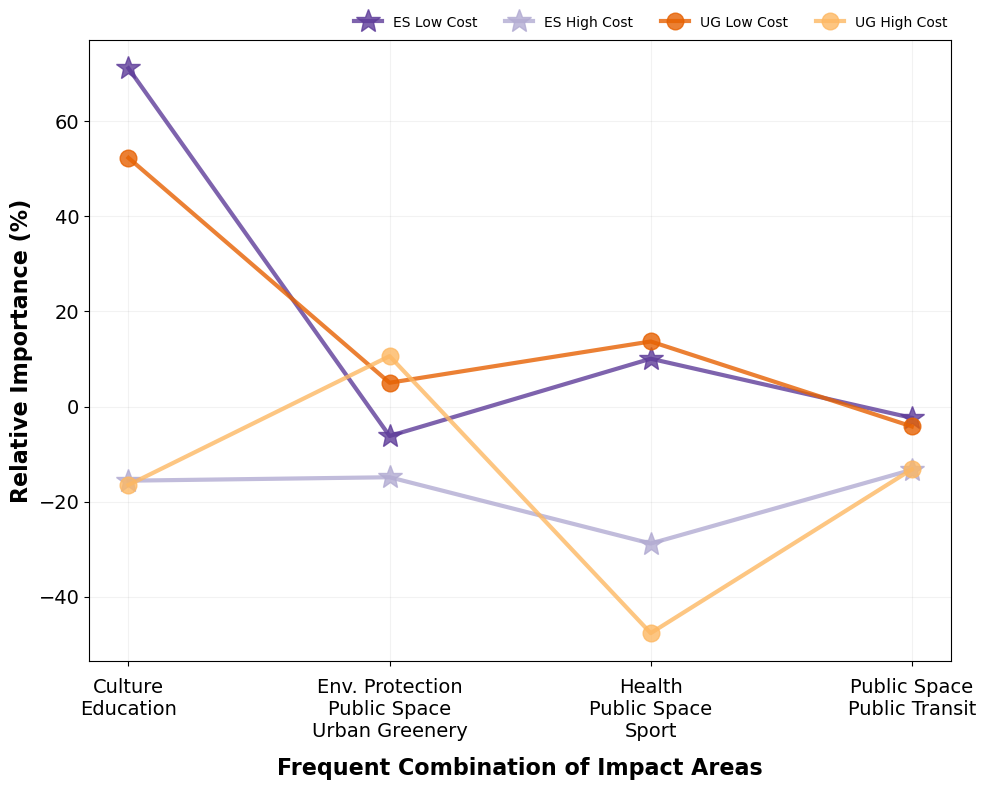

In [26]:
xlabels = ['Culture\nEducation', 
           'Env. Protection\nPublic Space\nUrban Greenery', 
           'Health\nPublic Space\nSport',
           'Public Space\nPublic Transit'
           ]
plt.figure(figsize=(10, 8))

y_mes = budget_utilization_df[(budget_utilization_df['result_type'] == 'mes') & (budget_utilization_df['metric'] == 'budget_utilization')]['relative_importance'].values
y_greedy = budget_utilization_df[(budget_utilization_df['result_type'] == 'greedy') & (budget_utilization_df['metric'] == 'budget_utilization')]['relative_importance'].values

y_mes_low = [y_mes[i] for i in range(len(y_mes)) if i % 2 == 0]
y_mes_high = [y_mes[i] for i in range(len(y_mes)) if i % 2 != 0]
y_ug_low = [y_greedy[i] for i in range(len(y_greedy)) if i % 2 == 0]
y_ug_high = [y_greedy[i] for i in range(len(y_greedy)) if i % 2 != 0]

# Plotting the data
plt.plot(xlabels, y_mes_low, marker='*', linewidth=3, markersize=18, color='#5e3c99', label='ES Low Cost', alpha=0.8)
plt.plot(xlabels, y_mes_high, marker='*', linewidth=3, markersize=18, color='#b2abd2', label='ES High Cost', alpha=0.8)
plt.plot(xlabels, y_ug_low, marker='o', linewidth=3, markersize=12, color='#e66101', label='UG Low Cost', alpha=0.8)
plt.plot(xlabels, y_ug_high, marker='o', linewidth=3, markersize=12, color='#fdb863', label='UG High Cost', alpha=0.8)

# Adding labels and title
plt.xlabel('Frequent Combination of Impact Areas', fontsize=16, fontweight='bold', labelpad=12)
plt.ylabel('Relative Importance (%)', fontsize=16, fontweight='bold')

plt.gca().xaxis.set_tick_params(pad=8)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis='both', which='major', color='gray', alpha=0.1)


# Customize legend
handles, labels = plt.gca().get_legend_handles_labels()

# Create legend outside of the main plot
plt.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.01, 1.06), ncols=8, frameon=False)

# Displaying the plot

plt.tight_layout()
plt.show()
